In [1]:
import scanpy as sc
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import seaborn as sns
import bbknn

In [2]:
import sys
sys.path.insert(0, "../lib")
import sankey
import script.scanpy as sc_utils

In [4]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["figure.figsize"] = (10, 10)
pd.set_option('display.max_rows', 500)

In [5]:
ds_full = sc.read_h5ad("../data/02dataset/integrated-manual.h5ad")

In [6]:
ephi = sc.read_h5ad("../data/02dataset/11epithelial.h5ad")
immu = sc.read_h5ad("../data/02dataset/12immune.h5ad")
stro = sc.read_h5ad("../data/02dataset/13stromal.h5ad")
endo = sc.read_h5ad("../data/02dataset/14endo.h5ad")

In [7]:
ds_full.obs["lineage"] = "None"
ds_full.obs["cluster"] = "Low quality, doublets"
for l, x in zip(("Epithelial", "Immune", "Stromal", "Endothelial"), (ephi, immu, stro, endo)):
    ds_full.obs.loc[x.obs_names, "cluster"] = x.obs.cluster
    ds_full.obs.loc[x.obs_names, "lineage"] = l
ds_full.obs.cluster.value_counts(dropna=False)

Low quality, doublets    34147
MoAM-1                   17395
TRAM-1                   15548
MoAM-2                   10032
Plasma cells              8718
AT2-2                     7801
Ciliated                  7315
MoAM-3                    6299
Fibroblasts-1             6160
TRAM-2                    6003
Fibroblasts-2, SCARA5     5971
AT2-1                     5940
Fibroblasts-3             4598
T cells                   4552
Fibroblasts-4             4319
Bronchial vessel          4303
TRAM-3                    4024
Capillary                 3378
Club                      3325
Smooth muscle-1           2999
Smooth muscle-2           2556
Mesothelial-1             2162
Mesothelial-2             2102
Endothelial-1             1988
Transitional AT2          1883
Basal 1                   1878
Lymphatic                 1856
Endothelial-2             1646
DCs                       1556
Basal 2                   1529
Artery                    1499
B cells                   1384
Basal 3 

In [8]:
ds_full.shape

(189560, 26214)

In [9]:
ds = ds_full.raw.to_adata()

In [10]:
ds = ds[ds.obs.cluster != "Low quality, doublets", :]

In [11]:
ds.shape

(155413, 26214)

/projects/b1038/tools/pyenv/versions/3.6.9/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'lineage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cluster' as categorical


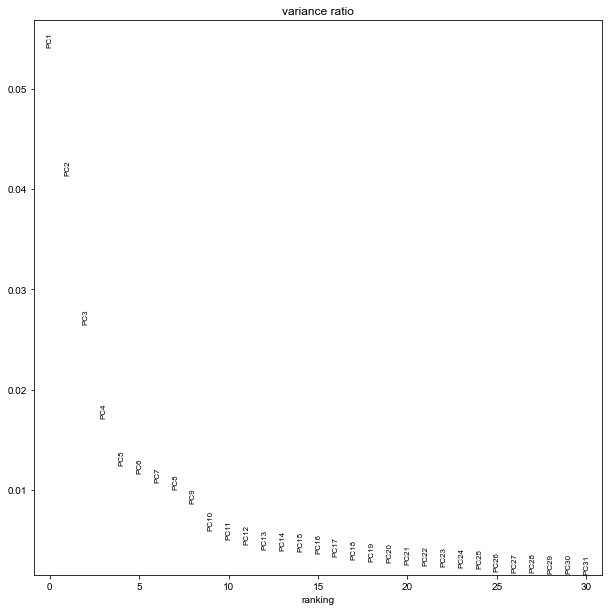

In [12]:
sc.pp.highly_variable_genes(ds, n_top_genes=3000, batch_key="orig.ident")
ds.raw = ds

sc.pp.scale(ds)
sc.tl.pca(ds, svd_solver="arpack")
sc.pl.pca_variance_ratio(ds)

In [13]:
bbknn.bbknn(ds, neighbors_within_batch=int(50 / ds.obs.batch.unique().size), n_pcs=20)

In [14]:
sc.tl.leiden(ds, resolution=0.75)
sc.tl.umap(ds)

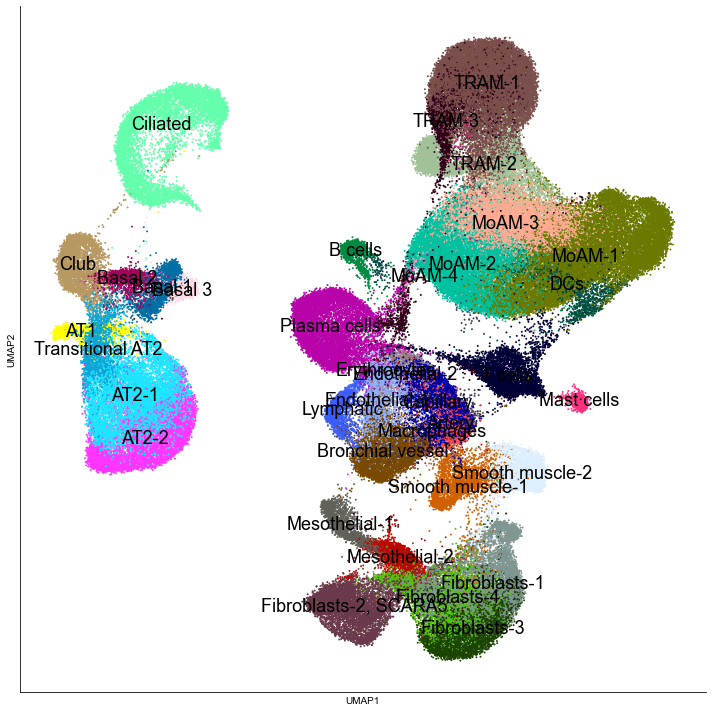

In [15]:
ax = sc.pl.umap(
    ds, 
    color="cluster", 
    size=15, 
    show=False, 
    legend_loc="on data",
    legend_fontsize=18, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/40full-umap.pdf")

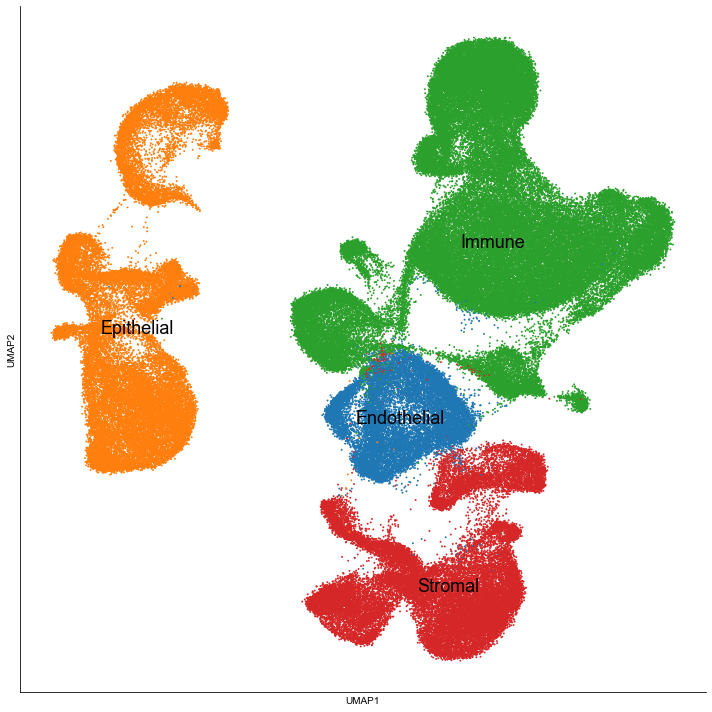

In [16]:
ax = sc.pl.umap(
    ds, 
    color="lineage", 
    size=15, 
    show=False, 
    legend_loc="on data",
    legend_fontsize=18, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/40full-lineage-umap.pdf")

In [ ]:
mpl.rcParams["figure.figsize"] = (12, 10)
ax = sc.pl.umap(
    ds, 
    color="orig.ident", 
    size=15, 
    show=False, 
#     legend_loc="on data",
    legend_fontsize=14, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/40full-sample-umap.pdf")

In [ ]:
mpl.rcParams["figure.figsize"] = (10, 10)
ax = sc.pl.umap(
    ds, 
    color="Sample Name", 
    size=15, 
    show=False, 
#     legend_loc="on data",
    legend_fontsize=18, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Patient", title_fontsize=14,
          frameon=False, fontsize=16, loc="upper right")#, bbox_to_anchor=(0.4, 1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/40full-patient-umap.pdf")

In [ ]:
left = np.zeros(len(ds.obs.cluster.unique()))
fig, ax = plt.subplots(figsize=(8, 10))
for s in sorted(ds.obs["Sample Name"].astype(str).unique()):
    cnt = ds.obs.cluster[ds.obs["Sample Name"] == s].value_counts().sort_index()
    ax.barh(list(reversed(cnt.index)), list(reversed(cnt.values)), left=left, label=s)
    left += list(reversed(cnt))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Patient", frameon=False, fontsize=14, title_fontsize=14)
# ax.set_title("Cluster by patient", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=12)#, rotation=45)
ax.tick_params(axis="y", labelsize=14)
# ax.set_xticklabels([
#     "CD4 T cells", "Tregs", "CD8 T cells", 
#     "Proliferating CD4 T cells", "Proliferating CD8 T cells",
#     "MoAM1", "MoAM2", "MoAM3", "TRAM1", "TRAM2"
# ], ha="right")
ax.set_xlabel("Number of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("plots/41global-composition.pdf")

In [19]:
ds.obs["COVID-19"] = ds.obs["COVID-19"].astype("category")

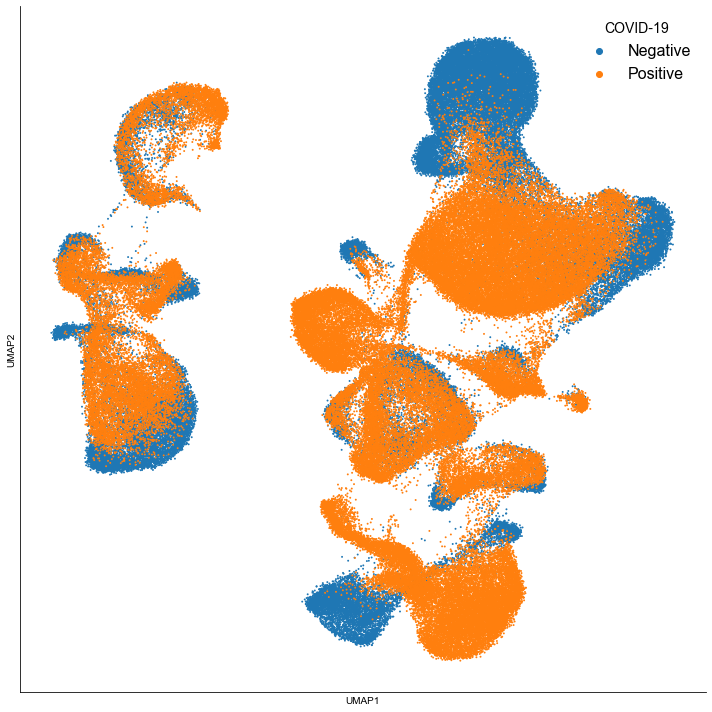

In [20]:
mpl.rcParams["figure.figsize"] = (10, 10)
ax = sc.pl.umap(
    ds, 
    color="COVID-19", 
    size=15, 
    show=False, 
#     legend_loc="on data",
    legend_fontsize=18, 
    legend_fontweight="normal",
#     legend_fontoutline=5
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Negative", "Positive"], title="COVID-19", title_fontsize=14,
          frameon=False, fontsize=16, loc="upper right")#, bbox_to_anchor=(0.4, 1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("plots/40full-covid-umap.pdf")

In [21]:
ds.write_h5ad("../data/02dataset/20global.h5ad")

In [25]:
sc.tl.rank_genes_groups(ds, "cluster", method="wilcoxon", n_genes=0)
markers = sc_utils.get_markers(ds, "cluster")

In [31]:
markers_trimmed = markers.groupby("cluster").head(500)

In [32]:
markers_trimmed.to_csv("../data/02dataset/20global-markers.csv")